#### 거리기반 K-Means의 문제점

* K-Means는 특정 중심점을 기반으로 거리적으로 퍼져있는 데이터 세트에 군집화를 적용하면 효율적 하지만 K-Means는 이러한 데이터 분포를 가지지 않는 데이터 세트에 대헤서는 효율적인 군집화가 어려움

## GMM(Gaussian Mixture Model) 개요

* GMM 군집화는 군집화를 적용하고자 하는 데이터가 여러 개의 다른 가우시안 분포(Gaussian Distribution)를 가지는 모델로 가정하고 군집화를 수행합니다.
* 가령 1000개의 데이터 세트가 있다면, 이를 구성하는 여러 개의 정규 분포 곡선을 추출하고, 개별 데이터가 이 중 어떤 정규 분포에 속하는지 결정하는 방식입니다.

### GMM 모수(Parameter) 추정

* GMM 모수 추정은 개별 정규 분포들의 평균과 분산, 그리고 데이터가 특정 정규 분포에 해당될 확률을 추정하는 것입니다.

### GMM 모수 추정을 위한 EM(Expectation and Maximization)

* Expectation : 개별 데이터 각각에 대해서 특정 정규 분포에 소속될 확률을 구하고, 가장 높은 확률을 가진 정규 분포에 소속(최초시에는 데이터들을 임의로 특정 정규 분포로 소속)

* Maximization : 데이터들이 특정 정규분포로 소속되면 다시 해당 정규분포의 평균과 분산을 구함. 해당 데이터가 발견될 수 있는 가능도를 최대화(Maximum likelihood) 할 수 있도록 평균과 분산(모수)를 구함


* 개별 정규분포의 모수인 평균과 분산이 더 이상 변경되지 않고, 각 개별 데이터들이 이전 정규 분포 소속이 더 이상 변경되지 않으면 그것으로 최종 군집화를 결정하고 그렇지 않으면 계속 EM 반복을 수행
    * EM : Expectation, Maximization

### 사이킷런 GaussianMixture

* 사이킷런은 GMM군집화를 위해 GaussianMixture 클래스를 제공
* GaussianMixture 클래스의 주요 생성자 파라미터는 n_components이며 이는 Mixture Model의 개수, 즉 군집화 개수를 의미

---

## GMM을 이용한 붓꽃 데이터 셋 클러스터링

In [3]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# 보다 편리한 데이터 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

#### GaussianMixture를 이용하여 붓꽃 데이터 군집화

In [4]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

# 클러스터링 결과를 irisDF의 'gmm_cluster' 컬럼명으로 저장
irisDF['gmm_cluster'] = gmm_cluster_labels

# target 값에 따라서 gmm_cluster 값이 어떻게 매핑되었는지 확인.
iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts() # target으로 먼저 그룹핑
print(iris_result)

target  gmm_cluster
0       0              50
1       2              45
        1               5
2       1              50
Name: gmm_cluster, dtype: int64


#### 붓꽃 데이터 K-Means 군집화 결과

In [5]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [8]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result) #

target  kmeans_cluster
0       1                 50
1       0                 48
        2                  2
2       2                 36
        0                 14
Name: kmeans_cluster, dtype: int64


#### 클러스터링 결과를 시각화하는 함수 생성

In [12]:
## 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체들을 인자로 받아 클러스터링 결과를 시각화하는 함수
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter:
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers = ['o', 's', '^', 'x', '*']
    isNoise = False
    
    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise = True
        else:
            cluster_legend = 'Cluster' + str(label)
            
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,
                   edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white')
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', 
                        edgecolor='k', marker='$%d$' % label)
            
    if isNoise:
        legend_loc = 'upper center'
    else:
        legend_loc = 'upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

#### GMM 군집화와 K-Means 군집화를 비교하기 위해 타원형으로 늘어선 임의의 데이터 세트를 생성

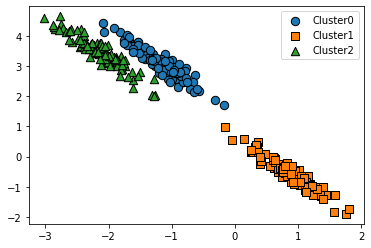

In [13]:
from sklearn.datasets import make_blobs

# make_blobs() 로 300개의 데이터 셋, 3개의 cluster 셋, cluster_std=0.5을 만듬
X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# 길게 늘어난 타원형의 데이터 셋을 생성하기 위해 변환함.
transformation = [ [0.60834549, -0.63667341], [-0.40887718, 0.85253229] ]
X_aniso = np.dot(X, transformation) # numpy 내적

# feature 데이터 셋과 make_blobs()의 y 결과 값을 DataFrame으로 저장
clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

# 생성된 데이터 셋을 target별로 다른 marker로 표시하며 시각화 함.
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

# 실제값 확인

#### K-Means 군집화 수행

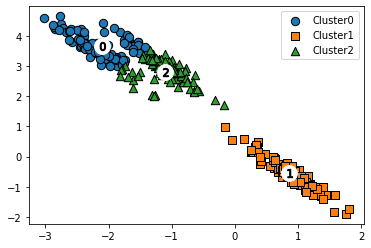

In [15]:
# 3개의 Cluster 기반 KMeans를 X_aniso 데이터 셋에 적용
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label', iscenter=True)

#### GMM 군집화 수행

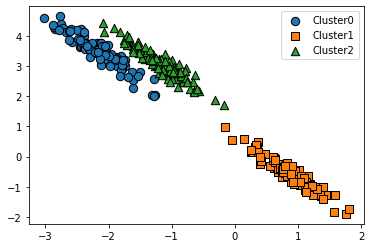

In [16]:
# 3개의 n_componenets 기반 GMM을 X_aniso 데이터 셋에 적용
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label'] = gmm_label

# GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter를 False로 설정
visualize_cluster_plot(gmm, clusterDF, 'gmm_label', iscenter=False)

#### GMM과 K-Means 군집화 비교

In [18]:
print('### KMeans clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMeans clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: kmeans_label, dtype: int64

### Gaussian clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: gmm_label, dtype: int64
